# **Sieć Neuronowa Od Podstaw w Pythonie**


## **Biblioteki**

In [1]:
import numpy as np # algebra liniowa
import matplotlib.pyplot as plt # używane do rysowania wykresów
from sklearn.datasets import load_digits # importowanie zbioru danych
from sklearn.model_selection import train_test_split # podział danych na część treningową i testową
from sklearn.preprocessing import MinMaxScaler # normalizacja danych
from sklearn.preprocessing import OneHotEncoder # kodowanie one-hot
import optuna # do hiperparametryzacji
import warnings # ignorowanie ostrzeżeń
warnings.filterwarnings("ignore")

/Users/mac/Coding/deep learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Klasa NeuralNetwork**
Metoda forward przyjmuje dane wejściowe X i przepuszcza je przez sieć. Oblicza sumy ważone (z1, z2) i stosuje funkcję aktywacji (sigmoid lub softmax, w zależności od funkcji straty) do tych sum, aby uzyskać aktywacje (a1, a2).

Dla warstwy ukrytej zawsze stosuje się funkcję aktywacji sigmoid. Dla warstwy wyjściowej używana jest funkcja softmax, jeśli funkcja straty to 'categorical_crossentropy', w przeciwnym przypadku używana jest funkcja sigmoidalna. Wybór między sigmoidą a softmaxem zależy od charakteru zadania (klasyfikacja binarna/wieloklasowa).

Ta metoda zwraca końcowy wynik (a2) sieci, który można wykorzystać do przewidywań.

Metoda backward implementuje algorytm wstecznej propagacji, który służy do aktualizacji wag i przesunięć w sieci na podstawie błędu między przewidywanym wyjściem a rzeczywistym wyjściem (y).

Oblicza gradienty funkcji straty dla wag i przesunięć (dw2, db2, dw1, db1) przy użyciu reguły łańcuchowej. Gradienty wskazują, o ile wagi i przesunięcia muszą zostać dostosowane, aby zminimalizować błąd.

Współczynnik uczenia (learning_rate) kontroluje, jak duży krok jest podejmowany podczas aktualizacji. Następnie metoda aktualizuje wagi i przesunięcia przez odjęcie iloczynu współczynnika uczenia i odpowiadających gradientów.

Różne obliczenia gradientowe są wykonywane w zależności od wybranej funkcji straty, co ilustruje elastyczność sieci w dostosowywaniu się do różnych zadań.

Funkcje aktywacji (metody sigmoid, sigmoid_derivative, softmax)
sigmoid: Ta metoda implementuje funkcję aktywacji sigmoidalną, która zmniejsza wartości wejściowe do zakresu od 0 do 1. Jest szczególnie przydatna w problemach klasyfikacji binarnej.

sigmoid_derivative: Oblicza pochodną funkcji sigmoidalnej, która jest używana podczas wstecznej propagacji do obliczania gradientów.

softmax: Funkcja softmax jest stosowana w problemach klasyfikacji wieloklasowej. Przekształca wyniki z sieci na prawdopodobieństwa, pobierając wykładnik dla każdego wyjścia, a następnie normalizując te wartości, aby sumowały się do 1.

In [13]:
class NeuralNetwork:
    """
    Prosta sieć neuronowa z jedną warstwą ukrytą.

    Parametry:
    -----------
    input_size: int
        Liczba cech wejściowych
    hidden_size: int
        Liczba neuronów w warstwie ukrytej
    output_size: int
        Liczba neuronów w warstwie wyjściowej
    loss_func: str
        Funkcja straty do użycia. Opcje to 'mse' dla błędu średniokwadratowego, 'log_loss' dla straty logistycznej i 'categorical_crossentropy' dla krzyżowej entropii kategorycznej.
    """
    def __init__(self, input_size, hidden_size, output_size, loss_func='mse'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_func = loss_func
        
        # Inicjalizacja wag i przesunięć
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        self.bias2 = np.zeros((1, self.output_size))

        # Śledzenie straty
        self.train_loss = []
        self.test_loss = []

    def __str__(self):
        """
        Wyświetl architekturę sieci neuronowej.
        """
        return f"Układ Sieci Neuronowej:\nWarstwa Wejściowa: {self.input_size} neuronów\nWarstwa Ukryta: {self.hidden_size} neuronów\nWarstwa Wyjściowa: {self.output_size} neuronów\nFunkcja Straty: {self.loss_func}"
        
    def forward(self, X):
        """
        Przeprowadź propagację w przód.
        
        Parametry:
        -----------
        X: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Przewidziane wyjście
        """
        # Przeprowadź propagację w przód
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        if self.loss_func == 'categorical_crossentropy':
            self.a2 = self.softmax(self.z2)
        else:
            self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate):
        """
        Przeprowadź propagację wsteczną.

        Parametry:
        -----------
        X: numpy array
            Dane wejściowe
        y: numpy array
            Docelowe wyjście
        learning_rate: float
            Współczynnik uczenia
        """
        # Przeprowadź propagację wsteczną
        m = X.shape[0]
        
        # Oblicz gradienty
        if self.loss_func == 'mse':
            self.dz2 = self.a2 - y
        elif self.loss_func == 'log_loss':
            self.dz2 = -(y/self.a2 - (1-y)/(1-self.a2))
        elif self.loss_func == 'categorical_crossentropy':
            self.dz2 = self.a2 - y
        else:
            raise ValueError('Nieprawidłowa funkcja straty')
        
        self.dw2 = (1 / m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1 / m) * np.sum(self.dz2, axis=0)
        self.dz1 = np.dot(self.dz2, self.weights2.T) * self.sigmoid_derivative(self.a1)
        self.dw1 = (1 / m) * np.dot(X.T, self.dz1)
        self.db1 = (1 / m) * np.sum(self.dz1, axis=0)
        
        # Zaktualizuj wagi i przesunięcia
        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1
        
    def sigmoid(self, x):
        """
        Funkcja aktywacji sigmoidalna.
        
        Parametry:
        -----------
        x: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Wynik funkcji sigmoidalnej
        """
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Pochodna funkcji aktywacji sigmoidalnej.

        Parametry:
        -----------
        x: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Wynik pochodnej funkcji sigmoidalnej
        """
        return x * (1 - x)
    
    def softmax(self, x):
        """
        Funkcja aktywacji softmax.

        Parametry:
        -----------
        x: numpy array
            Dane wejściowe
        
        Zwraca:
        --------
        numpy array
            Wynik funkcji softmax
        """
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)


## **Trainer Class**
Inicjalizuje listy train_loss i test_loss w celu śledzenia wartości strat podczas fazy treningu i testowania, umożliwiając monitorowanie wydajności modelu w czasie.

Obliczanie straty (metoda calculate_loss)
Ta metoda oblicza stratę pomiędzy przewidywanymi wynikami (y_pred) a prawdziwymi wynikami (y_true), korzystając z określonej funkcji straty. Jest to kluczowe dla oceny wydajności modelu i do przeprowadzania wstecznej propagacji.

Metoda obsługuje trzy rodzaje funkcji straty:

Mean Squared Error (‘mse’): Stosowane w zadaniach regresji, oblicza średnią kwadratów różnic między przewidywanymi a prawdziwymi wartościami.

Logistic Loss (‘log_loss’): Odpowiednie dla problemów klasyfikacji binarnej, oblicza stratę za pomocą metody log-wiarygodności.

Categorical Crossentropy (‘categorical_crossentropy’): Idealne do zadań klasyfikacji wieloklasowej, mierzy rozbieżność między prawdziwymi etykietami a przewidywaniami.

In [14]:
class Trainer:
    """
    Klasa do trenowania sieci neuronowej.

    Parametry:
    -----------
    model: NeuralNetwork
        Model sieci neuronowej do trenowania
    loss_func: str
        Funkcja straty do użycia. Opcje to 'mse' dla błędu średniokwadratowego, 'log_loss' dla straty logistycznej, i 'categorical_crossentropy' dla krzyżowej entropii kategorycznej.
    """
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.test_loss = []

    def calculate_loss(self, y_true, y_pred):
        """
        Oblicz stratę.

        Parametry:
        -----------
        y_true: numpy array
            Prawdziwe wyjście
        y_pred: numpy array
            Przewidziane wyjście
        
        Zwraca:
        --------
        float
            Strata
        """
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true*np.log(y_pred))
        else:
            raise ValueError('Nieprawidłowa funkcja straty')

    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate):
        """
        Trenuj sieć neuronową.

        Parametry:
        -----------
        X_train: numpy array
            Dane wejściowe treningowe
        y_train: numpy array
            Docelowe wyjście treningowe
        X_test: numpy array
            Dane wejściowe testowe
        y_test: numpy array
            Docelowe wyjście testowe
        epochs: int
            Liczba epok trenowania modelu
        learning_rate: float
            Współczynnik uczenia
        """
        for _ in range(epochs):
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a2)
            self.train_loss.append(train_loss)
            
            self.model.forward(X_test)
            test_loss = self.calculate_loss(y_test, self.model.a2)
            self.test_loss.append(test_loss)


Metoda train zarządza procesem uczenia przez określoną liczbę epok, korzystając z danych treningowych (X_train, y_train) i testowych (X_test, y_test). Przyjmuje również parametr learning_rate, który wpływa na wielkość kroku w aktualizacji parametrów podczas wstecznej propagacji.

Dla każdej epoki (cyklu treningowego) metoda wykonuje następujące kroki:

1. Przejście W Przód na Danych Treningowych: Wykorzystuje metodę forward modelu do obliczenia przewidywanych wyników dla danych treningowych.

2. Wsteczne Przejście (Aktualizacja Parametrów): Stosuje metodę backward modelu, wykorzystując dane treningowe i etykiety (y_train), oraz learning_rate do aktualizacji wag i przesunięć modelu na podstawie obliczonych gradientów z straty.

3. Obliczenie Straty Treningowej: Strata treningowa jest obliczana przy użyciu metody calculate_loss z etykietami treningowymi i przewidywaniami. Następnie ta strata jest dodawana do listy train_loss w celu monitorowania.

4. Przejście W Przód na Danych Testowych: Podobnie, metoda oblicza przewidywania dla danych testowych, aby ocenić wydajność modelu na danych niewidzianych podczas uczenia.

5. Obliczenie Straty Testowej: Oblicza stratę testową przy użyciu etykiet testowych i przewidywań, dodając tę stratę do listy test_loss.

## **Wczytywanie danych**
Zestaw danych używany tutaj to zestaw danych cyfr, który jest powszechnie stosowany do zadań klasyfikacji polegających na rozpoznawaniu ręcznie pisanych cyfr.

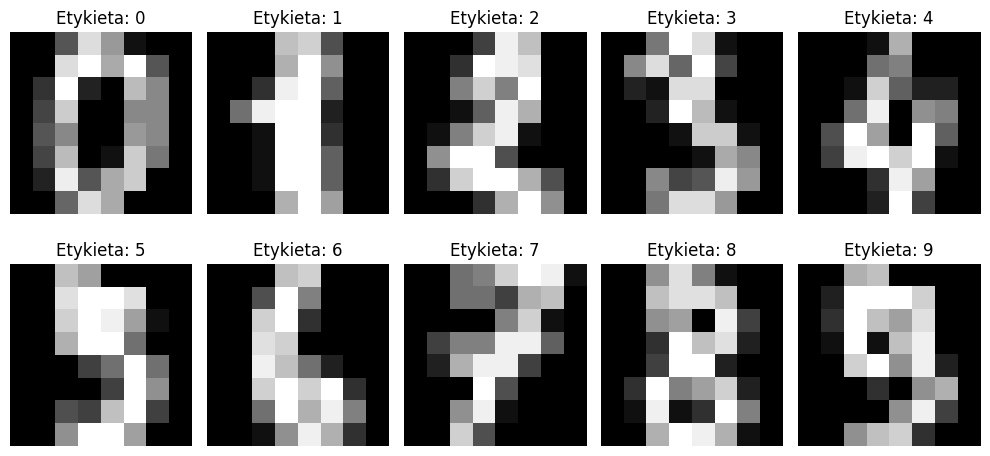

In [15]:
# Wczytaj zbiór danych dotyczący cyfr
cyfry = load_digits()

# Wyświetl pierwsze 10 obrazków
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(cyfry.images[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Etykieta: {cyfry.target[i]}")

plt.tight_layout()
plt.show()

## **Przetwarzanie danych**
Cechy zbioru danych są przeskalowane do zakresu od 0 do 1 za pomocą MinMaxScaler. Jest to powszechne przetwarzanie wstępne mające na celu zapewnienie, że wszystkie cechy wejściowe mają tę samą skalę, co może pomóc sieci neuronowej w skuteczniejszym uczeniu się.

Przeskalowane cechy są przechowywane w X, a etykiety docelowe (określające, jaką cyfrę reprezentuje każde zdjęcie) są przechowywane w y.
Ponieważ to zadanie klasyfikacji obejmuje wiele klas, etykiety docelowe są kodowane jednohotowkowo za pomocą OneHotEncoder. Kodowanie jednohotowkowe przekształca kategoryczne dane docelowe w format, który jest łatwiejszy do zrozumienia i pracy przez sieci neuronowe, zwłaszcza w przypadku zadań klasyfikacji.

Zestaw danych jest dzielony na zbiory treningowy i testowy za pomocą funkcji train_test_split, gdzie 80% danych jest używanych do treningu, a 20% do testów. Taki podział pozwala na trening modelu na jednej części danych, a następnie ocenę jego wydajności na oddzielnej, niewidocznej części, aby sprawdzić, jak dobrze generalizuje.

In [16]:
# Przetwórz zbiór danych
scaler = MinMaxScaler()
X = scaler.fit_transform(cyfry.data)
y = cyfry.target

# Dokonaj kodowania one-hot dla danych wyjściowych
koder = OneHotEncoder()
y_jednokodowane = koder.fit_transform(y.reshape(-1, 1))

# Podziel zbiór danych na zestawy treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y_jednokodowane, test_size=0.2, random_state=42)

## **Stworzenie SSN**



In [17]:
# Utwórz instancję klasy NeuralNetwork
rozmiar_wejscia = X.shape[1]
rozmiar_warstwy_ukrytej = 64
rozmiar_wyjscia = len(np.unique(y))
funkcja_straty = 'categorical_crossentropy'
epoki = 1000
wspolczynnik_uczenia = 0.1

nn = NeuralNetwork(rozmiar_wejscia, rozmiar_warstwy_ukrytej, rozmiar_wyjscia, funkcja_straty)

# Wyświetl architekturę sieci neuronowej
print(nn)

Układ Sieci Neuronowej:
Warstwa Wejściowa: 64 neuronów
Warstwa Ukryta: 64 neuronów
Warstwa Wyjściowa: 10 neuronów
Funkcja Straty: categorical_crossentropy


## **Trening SSN**

Po przeprowadzeniu treningu wydajność modelu jest oceniana na zbiorze testowym. Ponieważ cele zostały zakodowane na gorąco, funkcja np.argmax jest używana do przekształcenia zakodowanych na gorąco przewidywań z powrotem na postać etykiet. Dokładność modelu jest obliczana poprzez porównanie tych przewidywanych etykiet z rzeczywistymi etykietami (etykiety_y_test), a następnie wypisana.

Teraz ten kod brakuje kilku funkcji aktywacji, o których rozmawialiśmy, usprawnień takich jak SGD lub optymalizator Adam, i nie tylko. Pozostawiam to Tobie, abyś mógł uzupełnić luki swoim kodem. W ten sposób naprawdę opanujesz sieci neuronowe.

In [18]:
trener = Trainer(nn, funkcja_straty)
trener.train(X_train, y_train, X_test, y_test, epoki, wspolczynnik_uczenia)

# Przekonwertuj y_test z kodowania one-hot na etykiety
etykiety_y_test = np.argmax(y_test, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(nn.forward(X_test), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

ValueError: shapes (1437,64) and (1437,64) not aligned: 64 (dim 1) != 1437 (dim 0)

## **Plot Loss**

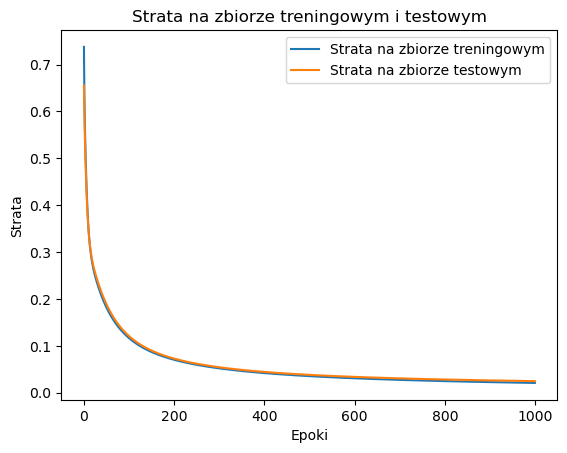

In [ ]:
plt.plot(trener.train_loss, label='Strata na zbiorze treningowym')
plt.plot(trener.test_loss, label='Strata na zbiorze testowym')
plt.title('Strata na zbiorze treningowym i testowym')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

## **Fine-Tune SSN !!**

In [ ]:
def cel(trial):
    # Definiuj hiperparametry
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    epochs = trial.suggest_int('epochs', 500, 10000)

    # Twórz i trenuj sieć neuronową
    nn = NeuralNetwork(rozmiar_wejscia, rozmiar_warstwy_ukrytej, rozmiar_wyjscia, funkcja_straty)
    trener = Trainer(nn, funkcja_straty)
    trener.train(X_train, y_train, X_test, y_test, epochs, learning_rate)

    # Oceniaj wydajność sieci neuronowej
    prognozy = np.argmax(nn.forward(X_test), axis=1)
    dokładność = np.mean(prognozy == etykiety_y_test)

    return dokładność

# Twórz obiekt badania i optymalizuj funkcję celu
badanie = optuna.create_study(study_name='nn_study', direction='maximize')
badanie.optimize(cel, n_trials=10)

# Drukuj najlepsze hiperparametry
print(f"Najlepsze badanie: {badanie.best_trial.params}")
print(f"Najlepsza wartość: {badanie.best_trial.value}")

[I 2024-04-05 10:17:09,928] A new study created in memory with name: nn_study
[I 2024-04-05 10:18:10,776] Trial 0 finished with value: 0.3861111111111111 and parameters: {'hidden_size': 98, 'learning_rate': 0.0005540564999109057, 'epochs': 9785}. Best is trial 0 with value: 0.3861111111111111.
[I 2024-04-05 10:18:19,119] Trial 1 finished with value: 0.03888888888888889 and parameters: {'hidden_size': 49, 'learning_rate': 0.00013337602615959065, 'epochs': 2282}. Best is trial 0 with value: 0.3861111111111111.
[I 2024-04-05 10:18:22,387] Trial 2 finished with value: 0.825 and parameters: {'hidden_size': 95, 'learning_rate': 0.04022409158733184, 'epochs': 888}. Best is trial 2 with value: 0.825.
[I 2024-04-05 10:18:24,282] Trial 3 finished with value: 0.09444444444444444 and parameters: {'hidden_size': 97, 'learning_rate': 0.0006415072681855609, 'epochs': 618}. Best is trial 2 with value: 0.825.
[I 2024-04-05 10:18:48,054] Trial 4 finished with value: 0.7888888888888889 and parameters: {'

Najlepsze badanie: {'hidden_size': 72, 'learning_rate': 0.016454642621342632, 'epochs': 8877}
Najlepsza wartość: 0.9527777777777777


## **Prognoza**

In [ ]:
best_nn = NeuralNetwork(rozmiar_wejscia, badanie.best_trial.params['hidden_size'], rozmiar_wyjscia, funkcja_straty)
best_trainer = Trainer(best_nn, funkcja_straty)
best_trainer.train(X_train, y_train, X_test, y_test, badanie.best_trial.params['epochs'], badanie.best_trial.params['learning_rate'])

# Oceń wydajność najlepszej sieci neuronowej
predictions = np.argmax(best_nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == etykiety_y_test)
print(f"Najlepsza dokładność: {accuracy:.2%}")

Najlepsza dokładność: 94.44%


## **To samo w TensorFlow**

In [ ]:
import tensorflow as tf
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Wczytaj zbiór danych cyfr
digits = load_digits()

# Przeskaluj cechy do zakresu od 0 do 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(digits.data)

# Zakoduj etykiety docelowe w formacie "one-hot"
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(digits.target.reshape(-1, 1))

# Podziel zbiór danych na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

## **Definija sieci**

In [ ]:
# Zdefiniuj architekturę modelu
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(len(np.unique(digits.target)), activation='softmax')
])

## **Skompiluj model**

In [ ]:
# Skompiluj model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## **Trening modelu**

In [ ]:
# Trenuj model
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), verbose=2)

# Oceń model na zestawie testowym
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Dokładność testowa: {test_accuracy:.2%}")

Epoch 1/1000
45/45 - 1s - loss: 1.9596 - accuracy: 0.4468 - val_loss: 1.6840 - val_accuracy: 0.6889 - 627ms/epoch - 14ms/step
Epoch 2/1000
45/45 - 0s - loss: 1.4010 - accuracy: 0.8107 - val_loss: 1.1302 - val_accuracy: 0.8528 - 82ms/epoch - 2ms/step
Epoch 3/1000
45/45 - 0s - loss: 0.9541 - accuracy: 0.8720 - val_loss: 0.7645 - val_accuracy: 0.9056 - 65ms/epoch - 1ms/step
Epoch 4/1000
45/45 - 0s - loss: 0.6632 - accuracy: 0.9179 - val_loss: 0.5458 - val_accuracy: 0.9056 - 58ms/epoch - 1ms/step
Epoch 5/1000
45/45 - 0s - loss: 0.4941 - accuracy: 0.9241 - val_loss: 0.4210 - val_accuracy: 0.9222 - 59ms/epoch - 1ms/step
Epoch 6/1000
45/45 - 0s - loss: 0.3966 - accuracy: 0.9374 - val_loss: 0.3466 - val_accuracy: 0.9250 - 56ms/epoch - 1ms/step
Epoch 7/1000
45/45 - 0s - loss: 0.3235 - accuracy: 0.9436 - val_loss: 0.2927 - val_accuracy: 0.9194 - 65ms/epoch - 1ms/step
Epoch 8/1000
45/45 - 0s - loss: 0.2786 - accuracy: 0.9485 - val_loss: 0.2573 - val_accuracy: 0.9361 - 57ms/epoch - 1ms/step
Epoch 